<a href="https://colab.research.google.com/github/811zhu/FinkelsteinFontolan_2021NN/blob/main/projects/behavior_and_theory/motor_RNNs100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Motor RNNs

contact: steeve.laquitaine@epfl.ch

Heavily inspired from [Feulner & Clopath, 2021](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008621)

## Setup

In [9]:
# import python packages
import os
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
from IPython import display

In [10]:
# @title Set the project path
proj_path = "proj_rnn/"
if not os.path.exists(proj_path):
  os.makedirs(proj_path)

# set the directories where the results will be saved
savedir = os.path.join(proj_path, 'data/fig2/')
if not os.path.exists(savedir):
  os.makedirs(savedir)

## Utils

### Network

In [11]:
# @title RNN encoder
class RNN(object):
    """
    Class implementing a recurrent network (not following Dale's law).

    Parameters:
    -----------
    * N: number of neurons
    * N_in: how many inputs can the network have
    * N_out: how many neurons are recorded by external device
    * g: recurrent coupling strength
    * p: connection probability
    * tau: neuron time constant
    * dt: set dt for simulation
    * delta: defines initial learning rate for FORCE
    * P_plastic: how many neurons are plastic in the recurrent network
    """
    def __init__(self, N=800, g=1.5, p=0.1, tau=0.1, dt=0.01,
                 N_in=6):
        # set parameters
        self.N = N
        self.g = g
        self.p = p
        self.K = int(p*N)
        self.tau = tau
        self.dt = dt

        # create recurrent W
        mask = np.random.rand(self.N,self.N)<self.p
        np.fill_diagonal(mask,np.zeros(self.N))
        self.mask = mask
        self.W = self.g / np.sqrt(self.K) * np.random.randn(self.N,self.N) * mask

        # create Win and Wout
        self._N_in = N_in
        self.W_in = (np.random.rand(self.N, self._N_in)-0.5)*2.

    @property
    def N_in(self):
        return self._N_in

    @N_in.setter
    def N_in(self, value):
        self._N_in = value
        self.W_in = (np.random.rand(self.N, self._N_in)-0.5)*2.

    def save(self,filename):
        np.savez(
            filename,
            N = self.N,
            K = self.K,
            tau = self.tau,
            g = self.g,
            p = self.p,
            dt = self.dt,
            W_in = self.W_in,
            W = self.W,
            N_in = self._N_in,
        )

    def load(self,filename):
        net = np.load(filename+'.npz')
        self.N = int(net['N'])
        self.dt = float(net['dt'])
        self.K = int(net['K'])
        self.tau = float(net['tau'])
        self.g = float(net['g'])
        self.p = float(net['p'])
        self.W_in = net['W_in']
        self.W = net['W']
        self._N_in = int(net['N_in'])

    def update_activation(self):
        self.z = np.tanh(self.r)

    def update_neurons(self,ext):
        self.r = self.r + self.dt/self.tau * \
             (-self.r + np.dot(self.W, self.z) + np.dot(self.W_in,ext))

        self.update_activation()

    def simulate(self, T, ext=None, r0=None):

        # define time
        time = np.arange(0,T,self.dt)
        tsteps = int(T/self.dt)

        # create input in case no input is given
        if ext is None:
            ext = np.zeros((tsteps,self.N_in))

        # check if input has the right shape
        if ext.shape[0]!=tsteps or ext.shape[1]!=self.N_in:
            print('ERROR: stimulus shape should be (time x number of input nodes)')
            return

        # set initial condition
        if r0 is None:
            self.r = (np.random.rand(self.N)-0.5)*2.
        else:
            self.r = r0
        self.update_activation()

        # start simulation
        record_r = np.zeros((tsteps,self.N))
        record_r[0,:] = self.r
        for i in range(1,tsteps):
            self.update_neurons(ext=ext[i])
            # store activity
            record_r[i,:] = self.r
        return time, record_r, np.tanh(record_r)

    def relearn(self, trials, ext, ntstart, decoder, feedback, target, delta=1.,
                wplastic=None):
        """
        Args
          self.z: RNN network's activation
          ext (np.array): stimuli (n_targets, n timesteps, n_targets)
          decoder (np.array): (N units, 2d coordinates) decoder weights
          feedback (np.array): (N units, 2d coordinates) feedback weights
          target: (n_targets, N timesteps, 2d coordinates) target coordinates

        Returns:

          loss (np.array): loss by trial
        """
        # get number of timesteps within trial
        tsteps = ext.shape[1]

        # set up learning
        if wplastic is None:
            self.W_plastic = [np.where(self.W[i,:]!=0)[0] for i in range(self.N)]
        else:
            self.W_plastic = wplastic
        self.P = [1./delta*np.eye(len(self.W_plastic[i])) for i in range(len(self.W_plastic))]

        # create n trials of target indices chosen from 0 to 5
        order = np.random.choice(range(ext.shape[0]), trials, replace=True)

        # initialize calculated loss per trial
        record_loss = np.zeros(trials)

        # loop over trials
        for t in range(trials):

            # initialize loss
            loss = 0.
            self.r = (np.random.rand(self.N)-0.5)*2.
            self.update_activation()

            # loop over time
            for i in range(1,tsteps):

                # update units
                self.update_neurons(ext=ext[order[t],i])

                # learn
                if i > ntstart and i%2==0:

                    # decode network's predicted
                    # target coordinates
                    c = decoder @ self.z

                    # calculate prediction error between
                    # decoded and true target coordinates (2,)
                    errc = c - target[order[t], i]

                    # calculate the error update assigned to each weight
                    err1 = feedback @ errc

                    # calculate loss
                    loss += np.mean(err1**2)

                    # update plastic recurrent weights
                    for j in range(self.N):
                        z_plastic = self.z[self.W_plastic[j]]
                        pz = np.dot(self.P[j], z_plastic)
                        norm = (1. + np.dot(z_plastic.T,  pz))
                        self.P[j] -= np.outer(pz, pz)/norm

                        # use error-transformed feedbacks to update
                        # plastic weights
                        self.W[j, self.W_plastic[j]] -= err1[j] * pz / norm

            # tape loss
            record_loss[t] = loss
            print('Loss in Trial %d is %.5f'%(t+1,loss))
        return record_loss

    def calculate_manifold(self, trials, ext, ntstart):
        tsteps = ext.shape[1]
        T = self.dt*tsteps
        points = (tsteps-ntstart)
        activity = np.zeros((points*trials,self.N))
        order = np.random.choice(range(ext.shape[0]),trials,replace=True)
        for t in range(trials):
            time, r, z = self.simulate(T,ext[order[t]])
            activity[t*points:(t+1)*points,:] = z[ntstart:,:]
        cov = np.cov(activity.T)
        ev,evec = np.linalg.eig(cov)
        pr = np.round(np.sum(ev.real)**2/np.sum(ev.real**2)).astype(int)
        xi = activity @ evec.real
        return activity,cov,ev.real,evec.real,pr,xi,order

def save_RNN(network, savedir:str):
  """write RNN object and weights in savedir
  """
  network.save(savedir+'network')
  np.save(savedir+'W_initial', network.W)

def save_RNN_sinewave(network, savedir:str):
  """write RNN sinewave object and weights in savedir
  """
  network.save(savedir + 'network_sinewave')
  np.save(savedir + 'W_initial_sinewave', network.W)

In [12]:
# @title BCI decoders
def train_reaching_decoder(inputP, target, order, n_output_units:int=2):
    """train the decoder to perform the six-cue
    motor reaching task
    """
    # initialize predictor neural activity
    X = np.zeros((inputP.shape[0]*inputP.shape[1], inputP.shape[-1]))

    # initialize predicted target
    Y = np.zeros((inputP.shape[0]*inputP.shape[1], n_output_units))

    # fill up
    for j in range(inputP.shape[0]):
        X[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = inputP[j]
        Y[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = target[order[j]]

    # regress target against neural activity
    reg = lm.LinearRegression()
    reg.fit(X,Y)

    # make predictions
    y = reg.predict(X)
    mse = np.mean((y-Y)**2)
    return reg.coef_, mse

def create_reaching_task_decoder(reaching_network, n_output_units:int=2):
  """create feedforward decoder from RNN to (x,y) output units
  for learning (random weights)"""

  # set parameters
  SCALE = 0.04
  DENOM = 0.2

  # create random weights
  reaching_decoder = np.random.randn(n_output_units, reaching_network.N)
  initial_decoder_fac = SCALE * (target_max / DENOM)

  # normalize decoder matrix
  reaching_decoder *= (initial_decoder_fac / np.linalg.norm(reaching_decoder))
  return reaching_decoder

def train_force_exertion_decoder(inputP, target, order, n_output:int=1):
    """train the decoder to perform the force exertion
    motor task. The network must apply force at
    oscillating amplitude (following a sinewave function
    of time)
    """

    # initialize predictor neural activity
    X = np.zeros((inputP.shape[0]*inputP.shape[1], inputP.shape[-1]))

    # initialize predicted target
    Y = np.zeros((inputP.shape[0]*inputP.shape[1], n_output))

    # fill up
    for j in range(inputP.shape[0]):
        X[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = inputP[j]
        Y[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = target[order[j]]

    # regress target against neural activity
    reg = lm.LinearRegression()
    reg.fit(X, Y)

    # make predictions
    y = reg.predict(X)
    mse = np.mean((y-Y)**2)
    return reg.coef_, mse

In [13]:
# @title Feedback weights
def get_feedback_weights(decoder):
  """calculate feedback weights from (x,y) output units back to RNN
  as the matrix inverse of the feedforward decoder weights from the RNN to
  the output units"""
  return np.linalg.pinv(decoder)

In [14]:
# @title Loss function
def get_cost(result, target, order):
  cost = 0
  for j in range(result.shape[0]):
    error = result[j, :, :] - target[order[j], :, :]
    cost += np.mean(error**2)
  return cost

In [15]:
# @title Get the manifold
def get_manifold(network):

  # calculate the manifold
  activity, cov, ev, evec, pr, xi, order = network.calculate_manifold(trials=manifold_trials, ext=stimulus, ntstart=pulse_length)

  # reshape the activity
  activity_reshaped = activity.reshape(manifold_trials, -1, network.N)
  xi2 = xi.reshape(manifold_trials, -1, network.N)
  return {"xi2":xi2, "order":order, "xi":xi, "cov":cov, "ev":ev, "evec":evec, "pr":pr,"activity":activity, "activity_reshaped":activity_reshaped}

def save_reaching_manifold(data, T):
  dic = {'manifold': {'original': data['manifold']}, 'perturbations': {'transformed':T}}
  np.save(savedir + 'reaching_relearning_results', dic)

def transform_reaching(reaching_network, manifold_out, W_bci4, n_output_units:int=2):

  P = manifold_out["evec"].real.T
  D = np.zeros((2, reaching_network.N))
  D[:,:reduced_dim] = W_bci4
  transformed = D @ P
  result = manifold_out["activity_reshaped"] @ transformed.T
  cost = get_cost(result, target[:,pulse_length:,:], manifold_out["order"])
  return transformed

In [16]:
# @title simulation
def simulate_reaching(savdir, dt):

  # set plot parameters
  COL_ORIG = 'k'
  ALPHA = 1

  # load velocity data
  data = np.load(savdir + 'reaching_relearning_results.npy', allow_pickle=True).item()
  activity = data['manifold']['original']['activity2']
  o_original = activity @ data['perturbations']['transformed'].T

  # reconstruct trajectories from velocities
  pos_original = np.zeros(o_original.shape)
  for j in range(activity.shape[1]):
      pos_original[:,j,:] = pos_original[:,j-1,:] + o_original[:,j,:]*dt

  # plot trajectories
  plt.figure(figsize=(15,10), dpi=96)
  plt.subplot(2,3,3)
  for j in range(manifold_trials):
      plt.plot(pos_original[j,:,0], pos_original[j,:,1], COL_ORIG, alpha=ALPHA);
  plt.title('simulated reaching');
  plt.xlabel('x-position on screen');
  plt.ylabel('y-position on screen');

### Task

In [17]:
# @title "reaching" task
def create_reaching_task_stimuli(tsteps:int, pulse_steps:int, n_targets:int=6, amplitude:float=1., twod:bool=False):
    """create the set of stimuli, which we sample from at each trial

    Args:
      tsteps (int):
      pulse_steps (int):
      n_targets (int):
      amplitude (float):
      twod (bool):

    Returns:
      (np.array): array of (n_targets, pulse_steps, n_targets) stimuli
    """

    # create stimulus
    stimulus = np.zeros((n_targets, tsteps, n_targets))
    if twod:
        phis = np.linspace(0,2*np.pi,targets,endpoint=False)
        for j in range(stimulus.shape[0]):
            stimulus[j,:pulse_length,0] = amplitude*np.cos(phis[j])
            stimulus[j,:pulse_length,1] = amplitude*np.sin(phis[j])
            stimulus[j,:pulse_length,2:] = 0
    else:
        for j in range(n_targets):
            stimulus[j,:pulse_steps,j] = amplitude
    return stimulus

def create_reaching_task_targets(tsteps, pulse_steps, n_targets:int=6, stype='constant', target_max:float=0.2):
    """create the set of target coordinates (6 by default) that the network
    must reach before the end of a trial. The network starts from the center of
    the computer screen (coordinate: (0,0))
    """
    # create target trajectories
    phis = np.linspace(0, 2*np.pi, n_targets, endpoint=False)
    rs = np.zeros(tsteps)

    # define each target's x and y coordinate
    rs[pulse_steps:] = np.ones(tsteps-pulse_steps)*target_max
    traj = np.zeros((n_targets,tsteps,2))
    for j in range(n_targets):

        # create x-coordinate on screen
        traj[j,:,0] = rs*np.cos(phis[j])

        # create y-coordinate on screen
        traj[j,:,1] = rs*np.sin(phis[j])
    return traj

def plot_reaching_task_stimuli(stimulus, n_targets:int, tsteps:int, T:int):

  # plot target cue with "pulse_steps" duration
  # at the beginning of each trial
  stimulus_set = np.arange(0, n_targets,1)

  fig, axes = plt.subplots(n_targets, 1, figsize=(30,9))

  for target in stimulus_set:
    axes[target].imshow(stimulus[target,:,:].T, aspect=10, cmap="binary");

    # legend
    axes[target].set_yticks(stimulus_set)
    axes[target].set_yticklabels(stimulus_set, fontsize=9)
    axes[target].set_xticks([0, tsteps])
    axes[target].set_xticklabels([0, T])
    axes[target].set_ylabel("possible targets", fontsize=9)

  axes[-1].set_xlabel("time within a trial (secs)")

  fig.tight_layout()

  print("stimuli:")
  print(f"-a set of {stimulus.shape[0]} possible trial stimuli (panels)")
  print(f"-{stimulus.shape[1]} timesteps within a trial stimulus")
  print(f"-{stimulus.shape[2]} possible cued target in a trial stimulus")

def plot_reaching_task_targets(target, tsteps:int, T:int):

  # count targets
  n_targets = target.shape[0]

  # plot target coordinates throughout trial
  fig, axes = plt.subplots(n_targets,1, figsize=(6,6))
  for target_i in tuple(range(n_targets)):
    axes[target_i].plot(target[target_i,:,:])

    # legend
    axes[target_i].set_xticks([0, tsteps])
    axes[target_i].set_xticklabels([0, T])
    axes[target_i].set_ylabel("target" "\n" "coord (a.u.)", fontsize=9)
    axes[target_i].set_ylim([target.min()-0.01, target.max()+0.01])

  axes[-1].set_xlabel("time within a trial (secs)")
  plt.legend(["x-coord", "y-coord"], fontsize=9, frameon=False)
  fig.tight_layout()

In [18]:
# @title "force" task
def create_force_task_stimuli(tsteps:int, pulse_steps:int, n_targets:int=1, amplitude:float=1., twod:bool=False):
    """create a stimulus set

    Args:
      tsteps (int):
      pulse_steps (int):
      n_targets (int):
      amplitude (float)
      twod (bool):

    Returns:
      (np.array): array of (n_targets, pulse_steps, n_targets) stimuli
    """

    # create stimuli
    stimulus = np.zeros((n_targets, tsteps, n_targets))
    for j in range(n_targets):
        stimulus[j,:pulse_steps,j] = amplitude
    return stimulus

def plot_force_stimuli(stimulus, n_targets:int, tsteps:int, T:int):

  # plot target cue with "pulse_steps" duration
  # at the beginning of each trial
  stimulus_set = np.arange(0, n_targets, 1)
  fig, axes = plt.subplots(n_targets, 1, figsize=(30,9))
  for target in stimulus_set:

    # plot
    axes[target].imshow(stimulus[target,:,:].T, aspect=10, cmap="binary");

    # legend
    axes[target].set_yticks(stimulus_set)
    axes[target].set_yticklabels(stimulus_set, fontsize=9)
    axes[target].set_xticks([0, tsteps])
    axes[target].set_xticklabels([0, T])
    axes[target].set_ylabel("possible targets", fontsize=9)
  axes[-1].set_xlabel("time within a trial (secs)")
  fig.tight_layout()
  print("stimuli:")
  print(f"-a set of {stimulus.shape[0]} possible trial stimuli (panels)")
  print(f"-{stimulus.shape[1]} timesteps within a trial stimulus")
  print(f"-{stimulus.shape[2]} possible cued target in a trial stimulus")

def create_force_task_targets(tsteps, pulse_steps, targets:list=[1, 10], target_max:float=0.2):
  """exert force with an oscillatorily increasing and decreasing amplitude
  """
  n_targets = len(targets)
  rs = np.zeros(tsteps)
  traj = np.zeros((n_targets, tsteps, 1))
  rs[pulse_steps:] = np.ones(tsteps - pulse_steps) * target_max
  x_coord = np.linspace(-2*np.pi, 2*np.pi, tsteps, endpoint=False)
  freq = []
  for ix in range(n_targets):
    traj[ix,:,0] = rs * np.sin(targets[ix] * x_coord)
  return traj

def plot_force_task_targets(target, tsteps:int, T:int):

  # count targets
  n_targets = target.shape[0]

  # plot target coordinates throughout trial
  fig, axes = plt.subplots(n_targets,1, figsize=(6,6));
  for target_i in tuple(range(n_targets)):

    # plot
    axes[target_i].plot(target[target_i,:,:]);

    # legend
    axes[target_i].set_xticks([0, tsteps]);
    axes[target_i].set_xticklabels([0, T]);
    axes[target_i].set_ylabel("target" "\n" "coord (a.u.)", fontsize=9);
    axes[target_i].set_ylim([target.min()-0.01, target.max()+0.01]);
  axes[-1].set_xlabel("time within a trial (secs)");
  plt.legend(["x-coord", "y-coord"], fontsize=9, frameon=False);
  fig.tight_layout();

## Create task 1: "reaching"

In [ ]:
# @title set parameters
# TODO: create dictionary

seed_id = 2                 # random seed for this simulation
np.random.seed(seed_id)

# time parameters
dt = 0.01                   # time discretization (secs, see paper table 1)
T = 2                       # trial duration (secs, see paper table 1)
time = np.arange(0, T, dt)
tsteps = len(time)          # number of time steps within a trial
pulse_length = int(0.2/dt)  # pulse length in number of timesteps

# network parameters
N = 800                     # RNN number of units
g = 1.5                     # RNN recurrent connection strengths (a.u)
p = 0.1                     # RNN connection probability
tau = 0.1                   # unit time constant tau (secs)
N_OUTPUT_UNITS = 2          # number of output units (2 for x and y)

# task parameters
targets = 6                 # number of reaching targets
stimulus_type = 'constant'  # constant, linear, normal
target_max = 0.2            # 0.2 or 0.01
n_learning1_trials = 80       # initial network learning
delta = 20.
relearning_trials = 80      # relearning
deltarec = 20.

# analyses parameters
manifold_trials = 50        # manifold calculation
reduced_dim = 10

stimuli:
-a set of 6 possible trial stimuli (panels)
-200 timesteps within a trial stimulus
-6 possible cued target in a trial stimulus


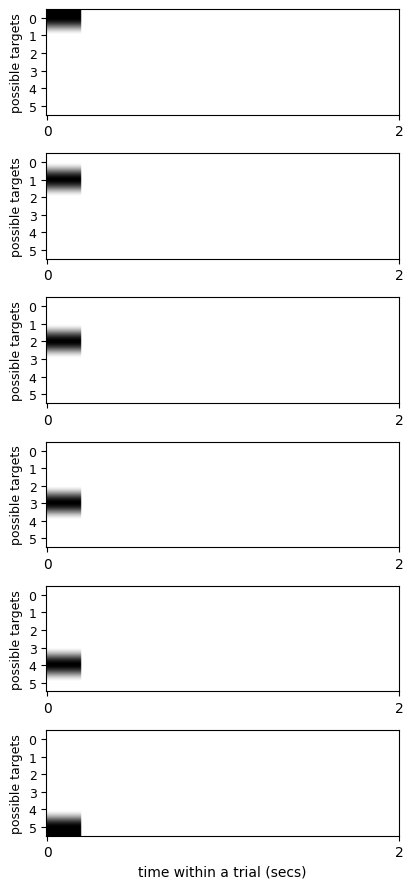

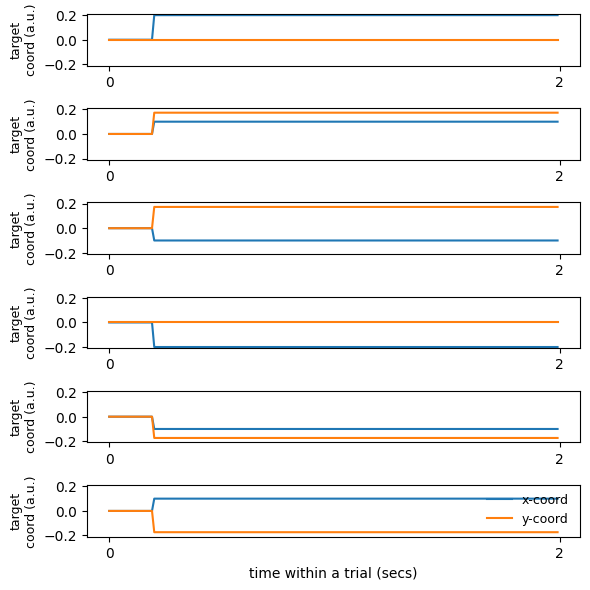

In [ ]:
# @title Create stimuli and targets

# create stimuli and plot
stimulus = create_reaching_task_stimuli(tsteps, pulse_length, twod=False)
plot_reaching_task_stimuli(stimulus, targets, tsteps, T)

# create target (targets x timesteps x 2D coordinates) and plot
target = create_reaching_task_targets(
    tsteps,
    pulse_length,
    n_targets=targets,
    stype=stimulus_type,
    target_max=target_max
    )
plot_reaching_task_targets(target, tsteps, T)

In [ ]:
# @title build and train the network
# create and save RNN encoder
reaching_network = RNN(N=N, g=g, p=p, tau=tau, dt=dt, N_in=targets)
save_RNN(reaching_network, savedir)

# create feedforward decoder from RNN to (x,y) output units
reaching_decoder = create_reaching_task_decoder(reaching_network,
                                                n_output_units=N_OUTPUT_UNITS)

# create feedback weights from (x,y) output units back to RNN
reaching_feedback = get_feedback_weights(reaching_decoder)

# train and save the RNN encoder weights (learn the task)
reaching_loss = reaching_network.relearn(n_learning1_trials, stimulus,
                                         pulse_length, reaching_decoder,
                                         reaching_feedback, target, delta=delta)
np.save(f'{savedir}W_stabilized_reaching', reaching_network.W)
w1_reaching = reaching_network.W.copy()

# get the RNN's manifold
manifold_out = get_manifold(reaching_network)

# train the decoder
W_bci4, l4 = train_reaching_decoder(manifold_out["xi2"][:, :, :reduced_dim],
                                    target[:, pulse_length:, :],
                                    manifold_out["order"],
                                    n_output_units=N_OUTPUT_UNITS)

# transform
transformed = transform_reaching(reaching_network, manifold_out,
                                 W_bci4, n_output_units=N_OUTPUT_UNITS)

Loss in Trial 1 is 0.36486


Loss in Trial 2 is 0.53443


Loss in Trial 3 is 0.07616


Loss in Trial 4 is 0.32136


Loss in Trial 5 is 0.40796


Loss in Trial 6 is 0.52334


Loss in Trial 7 is 0.12490


Loss in Trial 8 is 0.16206


Loss in Trial 9 is 0.05343


Loss in Trial 10 is 0.30051


Loss in Trial 11 is 0.64470


Loss in Trial 12 is 0.10505


Loss in Trial 13 is 0.42285


Loss in Trial 14 is 0.18380


Loss in Trial 15 is 0.14192


Loss in Trial 16 is 0.12791


Loss in Trial 17 is 0.47923


Loss in Trial 18 is 0.11559


Loss in Trial 19 is 0.35033


Loss in Trial 20 is 0.08278


Loss in Trial 21 is 0.06807


Loss in Trial 22 is 0.06301


Loss in Trial 23 is 0.09566


Loss in Trial 24 is 0.12736


Loss in Trial 25 is 0.23735


Loss in Trial 26 is 0.23559


Loss in Trial 27 is 0.17402


Loss in Trial 28 is 0.08763


Loss in Trial 29 is 0.17927


Loss in Trial 30 is 0.14406


Loss in Trial 31 is 0.08725


Loss in Trial 32 is 0.06780


Loss in Trial 33 is 0.12969


Loss in Trial 34 is 0.29347


Loss in Trial 35 is 0.06320


Loss in Trial 36 is 0.04275


Loss in Trial 37 is 0.05319


Loss in Trial 38 is 0.19063


Loss in Trial 39 is 0.18882


Loss in Trial 40 is 0.07958


Loss in Trial 41 is 0.10850


Loss in Trial 42 is 0.11297


Loss in Trial 43 is 0.18255


Loss in Trial 44 is 0.11546


Loss in Trial 45 is 0.07390


Loss in Trial 46 is 0.03333


Loss in Trial 47 is 0.38535


Loss in Trial 48 is 0.06997


Loss in Trial 49 is 0.07892


Loss in Trial 50 is 0.14193


Loss in Trial 51 is 0.07994


Loss in Trial 52 is 0.06952


Loss in Trial 53 is 0.10900


Loss in Trial 54 is 0.09297


Loss in Trial 55 is 0.10353


Loss in Trial 56 is 0.15564


Loss in Trial 57 is 0.10690


Loss in Trial 58 is 0.15024


Loss in Trial 59 is 0.10538


Loss in Trial 60 is 0.05267


Loss in Trial 61 is 0.05397


Loss in Trial 62 is 0.29171


Loss in Trial 63 is 0.01542


Loss in Trial 64 is 0.13387


Loss in Trial 65 is 0.05894


Loss in Trial 66 is 0.02853


Loss in Trial 67 is 0.07265


Loss in Trial 68 is 0.16341


Loss in Trial 69 is 0.18491


Loss in Trial 70 is 0.06880


Loss in Trial 71 is 0.15995


Loss in Trial 72 is 0.04211


Loss in Trial 73 is 0.13112


Loss in Trial 74 is 0.28417


Loss in Trial 75 is 0.06657


Loss in Trial 76 is 0.10395


Loss in Trial 77 is 0.17352


Loss in Trial 78 is 0.08851


Loss in Trial 79 is 0.05736


Loss in Trial 80 is 0.09944


In [ ]:
# @title Save run data
# format and save data for this run
run_data = {
    'params':{
        'dt':dt,
        'T':T,
        'time':time,
        'tsteps':tsteps,
        'pulse_length':pulse_length,
        'manifold_trials':manifold_trials,
        'target_max':target_max,
        'stimulus_type':stimulus_type,
        'N':N,
        'tau':tau,
        'g':g,
        'p':p
        },
    'stimulus':stimulus,
    'target':target,
    'stabilizing':{
        'learning_trials':n_learning1_trials,
        'delta':delta,
        'decoder':reaching_decoder,
        'feedback':reaching_feedback,
        'stabilize_loss':reaching_loss
        },
    'manifold':{
        'activity':manifold_out["activity"],
        'activity2':manifold_out["activity_reshaped"],
        'xi':manifold_out["xi"],
        'xi2':manifold_out["xi2"],
        'cov':manifold_out["cov"],
        'ev':manifold_out["ev"],
        'evec':manifold_out["evec"],
        'pr':manifold_out["pr"],
        'order': manifold_out["order"]
        },
    'decoding':{
        'reduced_dim': reduced_dim,
        'weights': W_bci4,
        'loss':l4
        }
        }
np.save(f'{savedir}reaching_experiment_results', run_data)

# save manifold data separately
save_reaching_manifold(run_data, transformed)

### simulate reaching

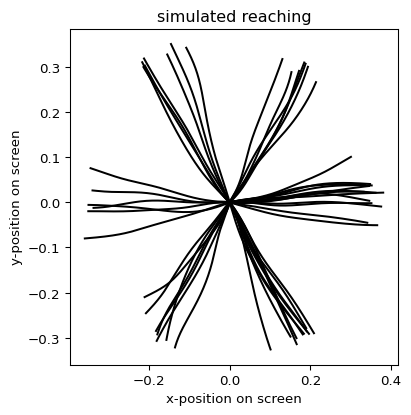

In [ ]:
# simulate reaching
trajectories = simulate_reaching(savedir, dt)

## Create task 2: "force"

Don't hesitate to use some of the utils functions that have been implemented for this tasks under the "force" task section.

Can you think of other tasks to test?

--- Phase 1: 1D Constant Force Training ---
Loss in Trial 1 is 0.00213
Loss in Trial 2 is 0.00039
Loss in Trial 3 is 0.00025
Loss in Trial 4 is 0.00039
Loss in Trial 5 is 0.00144
Loss in Trial 6 is 0.00018
Loss in Trial 7 is 0.00023
Loss in Trial 8 is 0.00030
Loss in Trial 9 is 0.00019
Loss in Trial 10 is 0.00049
Loss in Trial 11 is 0.00037
Loss in Trial 12 is 0.00030
Loss in Trial 13 is 0.00022
Loss in Trial 14 is 0.00017
Loss in Trial 15 is 0.00013
Loss in Trial 16 is 0.00012
Loss in Trial 17 is 0.00018
Loss in Trial 18 is 0.00047
Loss in Trial 19 is 0.00008
Loss in Trial 20 is 0.00003
Loss in Trial 21 is 0.00028
Loss in Trial 22 is 0.00010
Loss in Trial 23 is 0.00001
Loss in Trial 24 is 0.00035
Loss in Trial 25 is 0.00015
Loss in Trial 26 is 0.00022
Loss in Trial 27 is 0.00015
Loss in Trial 28 is 0.00020
Loss in Trial 29 is 0.00017
Loss in Trial 30 is 0.00034
Loss in Trial 31 is 0.00019
Loss in Trial 32 is 0.00037
Loss in Trial 33 is 0.00036
Loss in Trial 34 is 0.00014
Loss in Trial

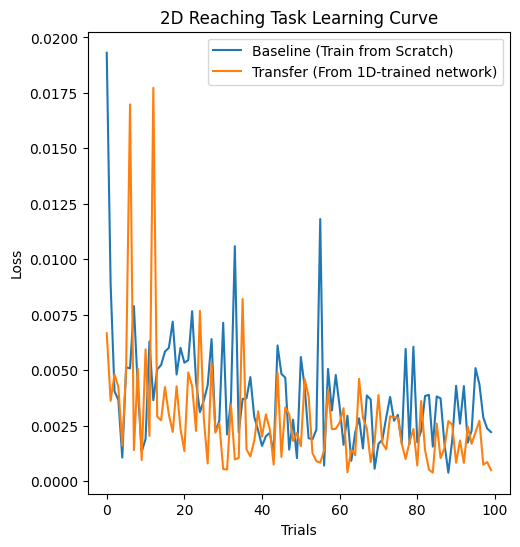

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model as lm

# (已包含在前面的代码中，这里不再重复)
# @title RNN encoder
# @title BCI decoders
# @title Feedback weights
# @title Loss function
# @title Get the manifold
# @title simulation

# --- 2. 任务和训练流程 ---

def generate_force_task(T, dt, n_targets=1, frequency=1.0, amplitude=1.0):
    """
    生成1D力量任务的目标信号 (Target) 和外部输入 (Ext).
    目标信号为恒定力量。
    """
    tsteps = int(T / dt)
    time_points = np.arange(0, T, dt)

    # 1D 目标信号: 恒定力量
    target = np.zeros((n_targets, tsteps, 1))
    target[0, :, 0] = 1.0  # 将正弦波替换为恒定值 1.0

    # 外部输入: 恒定信号，指示任务开始
    ext = np.zeros((n_targets, tsteps, 1))
    ext[0, :, 0] = 1.0 # 恒定输入

    return ext, target

def generate_reaching_task(T, dt, n_targets=8, radius=1.0, cue_duration=0.5):
    """
    生成2D运动任务的目标信号 (Target) 和外部输入 (Ext).
    目标信号为指向不同方向的平滑轨迹。
    """
    tsteps = int(T / dt)
    time_points = np.arange(0, T, dt)

    target = np.zeros((n_targets, tsteps, 2))
    ext = np.zeros((n_targets, tsteps, n_targets)) # One-hot 编码的输入

    # 定义8个目标位置
    theta = np.linspace(0, 2 * np.pi, n_targets, endpoint=False)
    target_pos = np.stack([radius * np.cos(theta), radius * np.sin(theta)], axis=1)

    # 创建平滑的轨迹
    for i in range(n_targets):
        # 目标位置
        T_pos = target_pos[i]

        # 轨迹插值
        start_time = int(cue_duration / dt)
        reach_t = time_points[start_time:] - time_points[start_time]
        reach_fraction = np.minimum(1.0, reach_t / (T - cue_duration))

        # 使用 sigmoid 函数平滑轨迹，确保速度从0开始和结束
        smooth_factor = 1 / (1 + np.exp(-10 * (reach_fraction - 0.5)))
        target[i, start_time:, :] = np.outer(smooth_factor, T_pos)

        # 外部输入: 在任务开始时激活相应维度
        ext[i, :start_time, i] = 1.0

    return ext, target

def main_experiment():
    """
    主实验流程：1D训练 -> 2D评估.
    """
    # --- 实验参数 ---
    T = 2.0  # 任务总时长 (秒)
    dt = 0.01 # 时间步长
    ntstart = 50 # 训练开始时间步
    trials_1d = 100 # 1D 任务训练的试验次数
    trials_2d = 100 # 2D 任务训练的试验次数

    # --- 第1阶段: 1D 力量任务训练 ---
    print("--- Phase 1: 1D Constant Force Training ---")

    # 1.1 生成1D任务数据
    ext_1d, target_1d = generate_force_task(T, dt, n_targets=1)
    n_out_1d = target_1d.shape[2]

    # 1.2 初始化网络
    network_1d = RNN(N_in=ext_1d.shape[2])

    # 1.3 训练前的基线表现
    time, r, z = network_1d.simulate(T, ext_1d[0])
    decoder_1d_initial, _ = train_force_exertion_decoder(z[np.newaxis,:,:], target_1d, np.array([0]), n_output=n_out_1d)

    # 1.4 训练网络
    initial_decoder_1d = np.random.randn(n_out_1d, network_1d.N)
    feedback_1d = get_feedback_weights(initial_decoder_1d)
    loss_1d = network_1d.relearn(trials_1d, ext_1d, ntstart, initial_decoder_1d, feedback_1d, target_1d)

    # 1.5 训练后的解码器和表现
    time, r, z_trained_1d = network_1d.simulate(T, ext_1d[0])
    decoder_1d_trained, mse_1d = train_force_exertion_decoder(z_trained_1d[np.newaxis,:,:], target_1d, np.array([0]), n_output=n_out_1d)

    # 1.6 保存1D训练后的网络权重和解码器
    np.savez('network_1d.npz', W=network_1d.W, W_in=network_1d.W_in)
    np.save('decoder_1d.npy', decoder_1d_trained)
    print(f"1D Training MSE: {mse_1d:.6f}")

    # --- 第2阶段: 2D 运动任务评估 (迁移测试) ---
    print("\n--- Phase 2: 2D Reaching Task Evaluation ---")

    # 2.1 生成2D任务数据
    ext_2d, target_2d = generate_reaching_task(T, dt, n_targets=8)
    n_out_2d = target_2d.shape[2]

    # 2.2 评估基线 (从头开始训练)
    print("--- Baseline: Train 2D from scratch ---")
    network_baseline = RNN(N_in=ext_2d.shape[2])
    initial_decoder_2d_baseline = np.random.randn(n_out_2d, network_baseline.N)
    feedback_2d_baseline = get_feedback_weights(initial_decoder_2d_baseline)
    loss_2d_baseline = network_baseline.relearn(trials_2d, ext_2d, ntstart, initial_decoder_2d_baseline, feedback_2d_baseline, target_2d)

    # 2.3 评估迁移 (使用1D训练的网络)
    print("--- Transfer: Relearn 2D from 1D-trained network ---")

    # 加载1D训练好的网络权重和解码器
    network_transfer = RNN(N_in=ext_2d.shape[2])
    net_1d_data = np.load('network_1d.npz')
    decoder_1d_trained = np.load('decoder_1d.npy')
    network_transfer.W = net_1d_data['W']

    # 为2D任务初始化新的解码器
    initial_decoder_2d_transfer = np.random.randn(n_out_2d, network_transfer.N)

    # 使用1D解码器初始化2D解码器的第一行，实现知识迁移
    initial_decoder_2d_transfer[0, :] = decoder_1d_trained[0, :]

    # 初始化反馈矩阵
    feedback_2d_transfer = get_feedback_weights(initial_decoder_2d_transfer)

    # 在加载的权重上继续训练
    loss_2d_transfer = network_transfer.relearn(trials_2d, ext_2d, ntstart, initial_decoder_2d_transfer, feedback_2d_transfer, target_2d)

    # --- 3. 结果分析与可视化 ---
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(loss_2d_baseline, label='Baseline (Train from Scratch)')
    plt.plot(loss_2d_transfer, label='Transfer (From 1D-trained network)')
    plt.xlabel('Trials')
    plt.ylabel('Loss')
    plt.title('2D Reaching Task Learning Curve')
    plt.legend()

    plt.show()

# 运行主实验
if __name__ == "__main__":
    main_experiment()